In [2]:
from IPython.display import Image,HTML
import matplotlib.pyplot as plt
%matplotlib inline

FSSC Science Tools
=========================
Fermi LAT Analysis: Overview
-------------------------
*Jeremy S. Perkins, FSSC*
*Based on S. Fegan's Lecture which was based on...*

**Goal:** *Understand how Likelihood is Implemented in the LAT Science Tools*

Goals of Any Analysis
============================
* Test for presence of a source, measure its position in the sky
* Extract fluxes of sources of interest. Measure flux vs. time (“lightcurve”) to test for variability.
* Measure spectra of sources
    * Parameters of fitted spectral type, e.g. index of power-law, energy of exponential cut-off, or “super”-exponential cutoff (pulsars)
    * Flux as function of energy (“flux in bands”) 

Last time we saw...
==========================
* Maximum likelihood is framework/cookbook for estimation and hypothesis testing
* To use, must produce accurate model of data (the rest is derived by following the cookbook)
* Some portions of model are of interest to us
* Others are not
    * Background sources
    * Observational response
* Must be mindful of systematic errors 

ScienceTools
=======================
* MLE and hypothesis testing is implemented for Fermi LAT data using ScienceTools.
* Data selection and binning into channels.
* Assists in producing of high-level sky model consisting of gamma-ray sources.
* Transforms sky model into low-level Poisson model for each channel (observational response).
* Estimation of parameters through optimization (“minimization”) using log-likelihood.
* Calculation of upper limits.

Data Exploration
==========================
* Photon files - list of photons in FITS format
    * Browser: http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi
    * All-sky: http://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/p7v6/
* Events reconstructed @SLAC and consist of:
    * Estimate of direction of origin
    * Estimate of the energy
    * “Probability” of being gamma ray (event classification)
    * Zenith angle, conversion point (front or back), detection time, ...

In [2]:
HTML("<iframe src='http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/' width='1000' height='500'></iframe>")

Data Before Cuts (4.8 years)
=============================

![cmap_nocuts](images/cmap_nocuts.png)

* Data set that we would like to analyze (using ML).
* Or in fact, it is a simplification.. the energy and time dependence are not shown! 

Data Set with Sensible Cuts
=============================
Appy Selection
* Zenith cut to remove photons from the Earth (∠Zn < 90deg)
* Photon class to select best reconstructed and lowest background (P8R2_Clean_V6)

![fullskywithcut](images/cmap_z100.png)

* Some part of the “background” can be removed: “cuts”. 
* Makes it easier to model (remaining) data.
* Rest cannot easily be separated: must be modeled. 

Region of Interest
=========================

![fullskyannote](images/cmap_z100_wCirc.png)

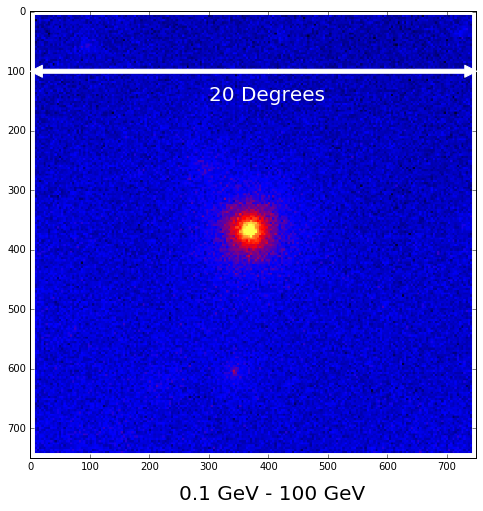

In [3]:
data = plt.imread('images/cmap_roi_example.png')
plt.figure(figsize=(8,8))
plt.imshow(data)

plt.annotate(
    '', xy=(0, 100), xycoords = 'data',
    xytext = (400, 100), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.annotate(
    '', xy=(750, 100), xycoords = 'data',
    xytext = (400, 100), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.text(300, 150, '20 Degrees',fontsize=20,color='white')
plt.text(250,820,"0.1 GeV - 100 GeV",fontsize=20)
plt.savefig('images/cmap_roi_example_annote.png')
plt.show()

Region of Interest
=======================

![full energy cmap](images/cmap_roi_example_annote.png)


Region of Interest
=======================
* Don’t have to analyze full sky at once! Select a region of interest (ROI) around source.
* Larger: better measure background (>TS)
* Smaller: faster & lower background subtraction systematics (maybe!)
* About 20 degrees is good compromise.


Channels of position and energy
====================================
0.1 GeV - 1 GeV
----------------------

<img src="images/cmap_roi_example_100.png" width='400'>


1 GeV - 10 GeV
----------------------

<img src="images/cmap_roi_example_1000.png" width='400'>

10 GeV - 100 GeV
----------------------

<img src="images/cmap_roi_example_10000.png" width='400'>

* Analyze events in channels of position and energy...
* ... as we are interested in spatial and energy dependence of sources
* ... best sensitivity achieved by using all information possible (as long as it can be modeled accurately!)

At higher energies there are fewer photon,
    1. Sources look less spread out (narrower PSF),
    2. There is less background.
At lower energies there are lots of photons,
    1. Sources look more spread out (broader PSF) and are more confused
    2. There is a lot of background!
Sources are most clearly detectable somewhere in the middle.

Data Collection Profile
========================

![2orbit](images/2orbit.png)

![cmapanimation](images/map_z100_ss20noX.gif)

* Modeling must also account for the “observing profile”.
* Rate of γ rays from source depends on its (constantly changing) position in the field of view of the LAT. 

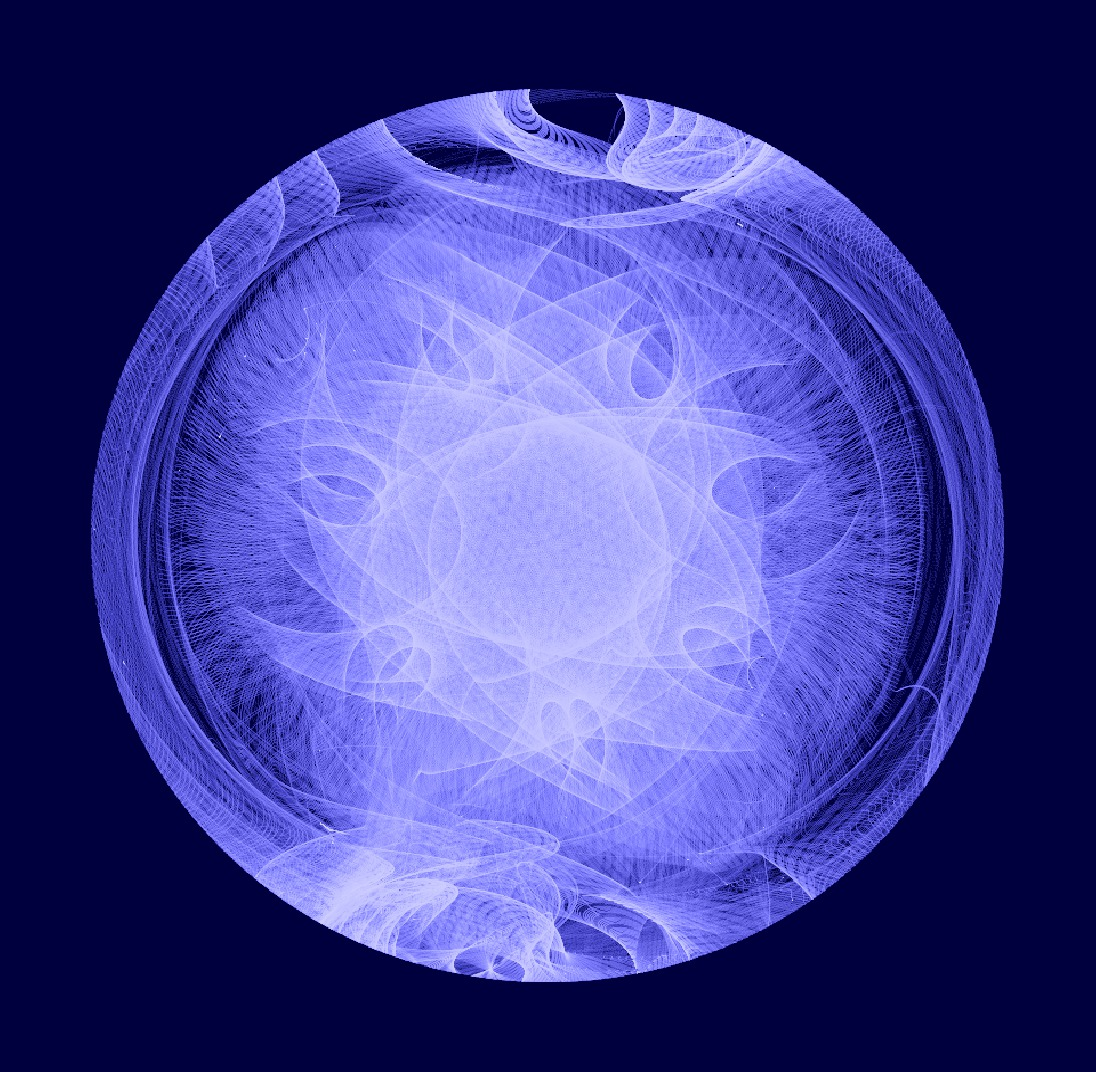

In [112]:
Image("http://apod.nasa.gov/apod/image/1205/LatPolar_Vela.jpg")

Model
====================
* Sky model
    * Spatial distribution of sources in ROI (point-like and extended sources)
    * Spectral model for each source
* Observational response (“exposure”)
    * Observational profile
    * Instrument response functions (IRFs)

Sky Model
===================
* Spatial and spectral model
* Point sources	(coordinates: RA & Dec)
* Extended sources	(map of emission)
* Diffuse sources	(full sky maps)
* Spectral types	(e.g. power law - index, flux)
* No time dependence!
* All these encoded in an XML input file
    * ST and LAT catalogs can help with this task 

Model for our Sample ROI
=============================
* Sources from 3FGL catalog in and near the ROI
    * Best-fit locations and spectral types (2yr)
* Diffuse isotropic
    * Extragalactic diffuse gamma rays
    * Local cosmic ray background
* Galactic diffuse
    * Cosmic ray interactions
* Local sources of gamma rays: Earth limb, also the Sun and Moon 

![model locations](images/cmap_roi_example_1000_annote.png)

Model for our Sample ROI
===============================

* Point Sources: $$S(E,\hat{p},t) = \sum_i s_i(E,t)\delta(\hat{p}-\hat{p}_i)$$
* Galactic Diffuse: $$+ S_G(E,\hat{p})$$ 
* Extragalactic and Residual: $$+ S_{eg}(E,\hat{p})$$ 
* Other Extended Sources (Optional): $$+ \sum_l S_l(E,\hat{p},t)$$ 

Example for a power law spectral model
---------------------------------

$$S(E,\hat{p},t) = S(E,F_0,\Gamma,E_0) = F_0(\frac{E}{E_0})^{-\Gamma}$$


Observational Profile
===========================
* Pointing records from spacecraft file - every 30 seconds
* RA & Dec of LAT pointing direction, the z-axis
    * (and of x-axis for phi dependence)
* Observation mode - sky survey, pointed
* See the Data Exploration Notebook for a description 

Instrument Response Functions
================================
* Effective Area - how the photon collecting area depends on energy and angle
* Point Spread Function (PSF) - how the reconstructed photon angles from a point source are distributed around the true direction in the sky
* Energy Dispersion - how reconstructed photon energy is distributed around the true energy - **often neglected in analysis but important for Pass 8 below ~100 MeV**
* IRF set must match event selection used in analysis, eg. “P8R2_SOURCE_V6” 

Effective Area (EA)
=============================

![EASlide](images/EA_P8R2_SOURCE_V6.png)

* Collecting area for events with TRUE energy E, and TRUE angles in spacecraft(θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 


Point Spread Function
================================

![PSF](images/PSF_P8R2_SOURCE_V6.png)

* Point-spread function for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Energy Dispersion
================================

![energy dispersion](images/Edisp_P8R2_SOURCE_V6.png)

* Energy dispersion for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ)

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Observational Response
===============================
![Observational Response](images/obs_resp.png)

Observational Response
==============================

Instantaneous Response(Measured Params,True Params, Time) = EA x PSF x ED

$$R_t(E, \vec{p}, E^T, \vec{p^T},t) = A(E^T, \vec{p^T},t)
\times P(\vec{p},\vec{p^T},E^T,t) 
\times D(E; E^T,\vec{p},\vec{p^T},t)$$

Total Response

$$R(E, \vec{p}; E^T, \vec{p^T}) = \int dt R_t(E, \vec{p}; E^T,\vec{p^T},t)$$

Total 'Exposure' in units of cm<sup>2</sup>s

$$\int_0^\infty dE  \int _{4\pi} d\vec{p}\ R(E, \vec{p}, E^T, \vec{p^T})
= \int_{t_0}^{t_1} dt A(E^T, \vec{p^T},t) = X(E^T,\vec{p^T})$$

Define average PSF and ED

$$R(E,\vec{p}, E^T, \vec{p^T}) = X(E^T,\vec{p^T}) \bar{P}(\vec{p},\vec{p^T},E^T) \bar{D}(E,E^T,\vec{p},\vec{p^T})$$

'Exposure' vs Time
=============================

![exposure](images/exposure.png)

* Instantaneous exposure for some source.
* Systematics may be present on short timescales or in some temporal analyses.
* See http://fermi.gsfc.nasa.gov/ssc/data/analysis/LAT_caveats_temporal.html


"Binned" or "Unbinned" (or Both)
===================================
The maximum likelihood estimation in the _Science Tools_ can be applied to data binned in energy and space, or by treating each photon as a bin, i.e. unbinned analysis. You can see how this works in the formalism below.

"Binned" Likelihood Function
=================================
* Events binned into channels,_i_,of energy and position in sky:
$$(E_i, \vec{p}_i)$$
of size
$$\Delta E_i\Delta\vec{p}_i : n_i$$
* Log likelihood is (as in yesterday’s talk):
$$ln\mathcal{L}(\Theta) = \sum_{i\in Bins} n_i \ln \lambda_i(\Theta) - N_{pred}(\Theta)$$
* The Poisson mean for each channel is (ignoring ED in the second line):
$$\lambda_i(\Theta) = \Delta E_i\Delta\vec{p}_i \int dE^T \int_{ROI+} d\vec{p^T}
 S(E^T, \vec{p^T}|\Theta) R(E_i, \vec{p}_i, E^T, \vec{p^T})$$
$$= \Delta E_i\Delta\vec{p}_i \int_{ROI+} d\vec{p^T}
 S(E_i, \vec{p^T}|\Theta) R(E_i, \vec{p}_i, \vec{p^T})$$
* As expected:
$$N_{pred} = \sum_i \lambda_i(\Theta)$$


"Unbinned" Likelihood Function
===================================
* Infinitesimal channels in energy, position, time and event type, so 
$$n_i\in\{0,1\}$$
* The log likelihood is:
$$\ln\mathcal{L}(\Theta) = \sum_{i\in Events} \ln \lambda_i(\Theta) - N_{pred}(\Theta)$$
* Ignoring ED, the Poisson mean (density) for each channel (event) is:
$$\lambda_i(\Theta) = \int_{ROI+} d\vec{p^T}
 S(E_i, \vec{p^T}|\Theta) R_t(E_i, \vec{p}_i, \vec{p^T},t_i,type_i)$$
*And:
$$N_{pred}(\Theta) = \sum_{type} \int dE \int_{ROI} d\vec{p} \int dt \int_{ROI+} d\vec{p^T} \int dt
S(E,\vec{p^T}|\Theta) R_t(E, \vec{p}, \vec{p^T},t,type)$$

"Binned" or "Unbinned" (or both)?
=================================
* Binned - _recommended for most analysis by LAT collaboration_
    * Faster for large data sets (averaged IRFs)
    * Diffuse source calculation simpler
* Unbinned - _useful in certain circumstances_
    * Slow for large data sets (IRF for each event)
    * Diffuse source calculation very slow (but can be pre-calculated)
    * TS values may be higher than binned analysis if choice of bin size dilutes photon information
* Mixed - “Composite Likelihood”
    * Advanced - You can have your cake and eat it, too! For example, you can use binned at lower energy where the PSF is broad and photons are numerous and switch to unbinned at higher energy where photons are more sparse in energy and position. But in most cases this is not necessary.



Analysis Flow - Binned
=========================
1. Extract data (`gtselect/gtmktime`)
2. Bin data into counts cube in energy and space (`gtbin`)
3. Compute observation profile (`gtltcube`)
4. Compute exposure cube (`gtexpcube2`)
5. Create sky model
6. Produce source maps (`gtsrcmaps`)
7. Run Maximum Likelihood estimation (`gtlike`)
8. Evaluate outputs, e.g., spatial and spectral residuals - is the best fit a "good" fit?

What Does This Analysis Give Us?
=================================
* Convergence status
* Estimates for all free parameters in the model (from maximizing likelihood)
* The covariance matrix (from 2nd derivative at MLEs) → Gaussian errors on parameters
* Flux and predicted number of photons from each source for best-fit parameters
* Test Statistic for each source with a free parameter (corresponds to detection significance)
* Residual counts for the total model compared to the data over the full region of interest 